# Curve LP Metrics Data Exploration

TODO:
1. Ensure that we are getting correct data from each subgraph

    Known issues:

    a. Potentially wrong swap and LP event data from Messari.
    
    b. Convex community subgraph does not have data on pool reserve balances.

    Solution?

    Get data from both subgraphs. Use reserves data from Messari. Compare swaps and LP event data between subgraphs and identify where there are discrepancies. Assume convex-community subgraph is the source of truth: identify patterns for when/how Messari's is wrong and bring it to Benny + raise issue in Messari's repo.
2. Remove MIT license
3. Think more about diff between D/W and swaps
4. Think more about LP profitability (not necessarily markout) (F-score also cool for regime shift detection backtest)
5. Start looking into regime shift detection (std, bollinger band, Markov switching)
6. Find a way to get Curve prices (either constructed from reserves or from subgraph if possible)
7. code for each metric -> df wrt each pool that tracks all the relevant metrics -> regime shift detection -> lp profitability -> run regime shift detection of metrics df and compare to lp profitability -> API

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datafetcher import DataFetcher
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Data Fetching using Messari

In [4]:
pool_name = '3pool'
datafetcher = DataFetcher('2023-03-01', '2023-04-01')
df_pool = datafetcher.get_pool_data(pool_name) # optionally save=True
df_swaps = datafetcher.get_swaps_data(pool_name) # optionally save=True
df_lp = datafetcher.get_lp_data(pool_name) # optionally save=True
# NOTE: takes abt ~30s to run this cell for a month with step_size=50

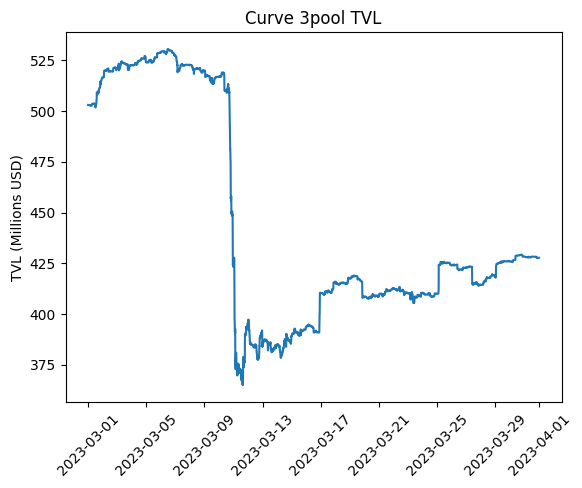

In [5]:
fig, ax = plt.subplots()

ax.plot(df_pool.index, df_pool['totalValueLockedUSD']/1e6, label='totalValueLockedUSD')
ax.set_ylabel('TVL (Millions USD)')
ax.set_title(f"Curve {pool_name} TVL")
ax.tick_params(axis='x', rotation=45)

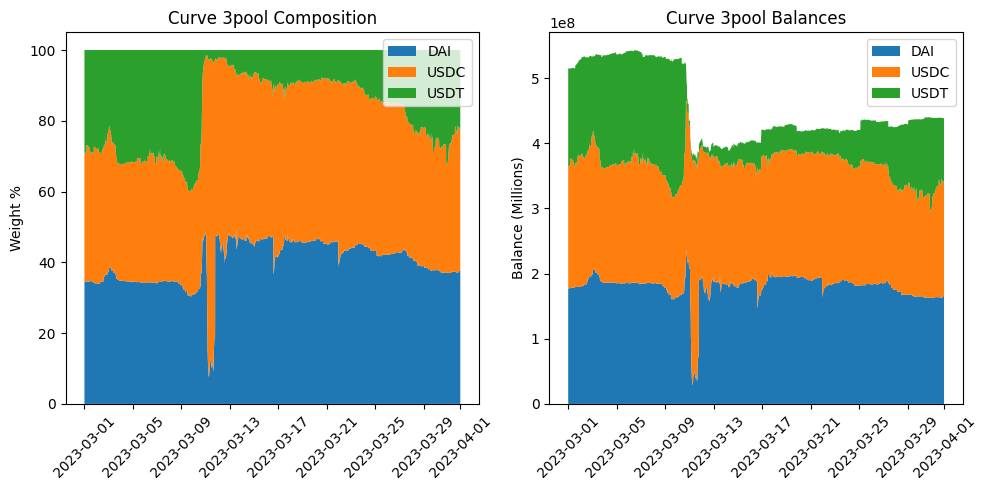

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].stackplot(df_pool.index, df_pool['DAI.weight'], df_pool['USDC.weight'], df_pool['USDT.weight'], labels=['DAI', 'USDC', 'USDT'])
axs[0].set_ylabel('Weight %')
axs[0].set_title(f"Curve {pool_name} Composition")
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()

axs[1].stackplot(df_pool.index, df_pool['DAI.balance'], df_pool['USDC.balance'], df_pool['USDT.balance'], labels=['DAI', 'USDC', 'USDT'])
axs[1].set_ylabel('Balance (Millions)')
axs[1].set_title(f"Curve {pool_name} Balances")
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

fig.tight_layout()

# Swap Metrics

In [7]:
df_swaps['tokenIn.symbol'].unique()

array(['DAI', 'USDC', 'USDT'], dtype=object)

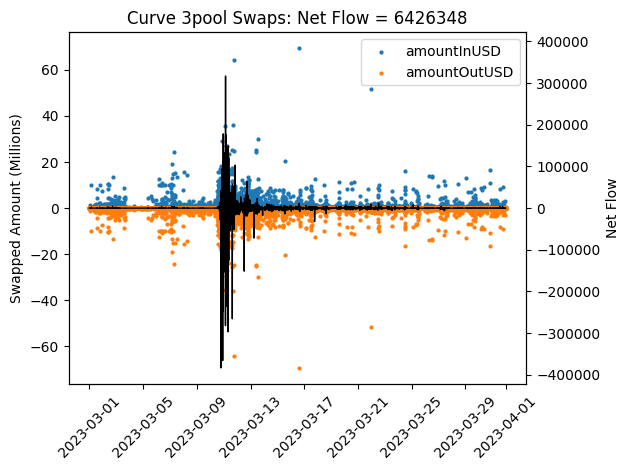

In [8]:
freq = '1min'

fig, ax = plt.subplots()

swaps_in = df_swaps['amountInUSD'].resample(freq).sum()
swaps_out = -1*df_swaps['amountOutUSD'].resample(freq).sum()

flow = pd.concat([swaps_in, swaps_out], axis=1).fillna(0)
flow['netFlow'] = flow['amountInUSD'] + flow['amountOutUSD']

maskIn = flow[flow['amountInUSD'] != 0]
maskOut = flow[flow['amountOutUSD'] != 0]

ax2 = ax.twinx()

ax2.plot(flow.index, flow['netFlow'], label='netFlow', color='black', linewidth=1)
ax.scatter(maskIn.index, maskIn['amountInUSD']/1e6, label='amountInUSD', s=4)
ax.scatter(maskOut.index, maskOut['amountOutUSD']/1e6, label='amountOutUSD', s=4)

left_max = max(max(maskIn['amountInUSD']/1e6), -1*min(maskIn['amountOutUSD']/1e6))*1.1
ax.set_ylim(-left_max, left_max)

right_max = max(abs(flow['netFlow']))*1.1
ax2.set_ylim(-right_max, right_max)
ax2.set_ylabel('Net Flow')

ax.set_ylabel('Swapped Amount (Millions)')
ax.set_title(f"Curve {pool_name} Swaps: Net Flow = {round(flow['netFlow'].sum())}")
ax.tick_params(axis='x', rotation=45)

ax.legend()

fig.tight_layout()

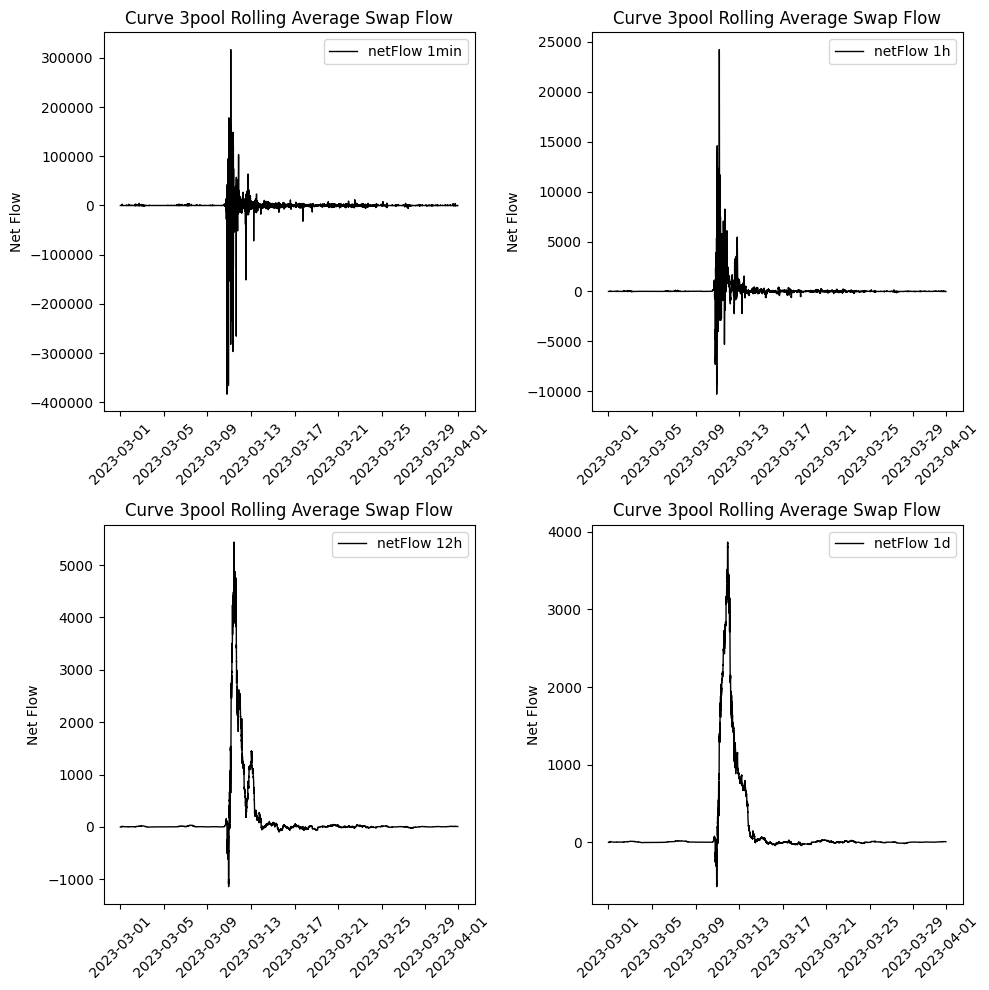

In [9]:
windows = ['1min', '1h', '12h', '1d']

n, m = 2, 2

fig, axs = plt.subplots(n, m, figsize=(10, 10))
count = 0
for i in range(n):
    for j in range(m):
        window = windows[count]
        axs[i, j].plot(flow.index, flow['netFlow'].rolling(window).mean(), label=f'netFlow {window}', color='black', linewidth=1)

        axs[i, j].set_ylabel('Net Flow')
        axs[i, j].set_title(f"Curve {pool_name} Rolling Average Swap Flow")
        axs[i, j].tick_params(axis='x', rotation=45)

        axs[i, j].legend()
        count += 1

fig.tight_layout()

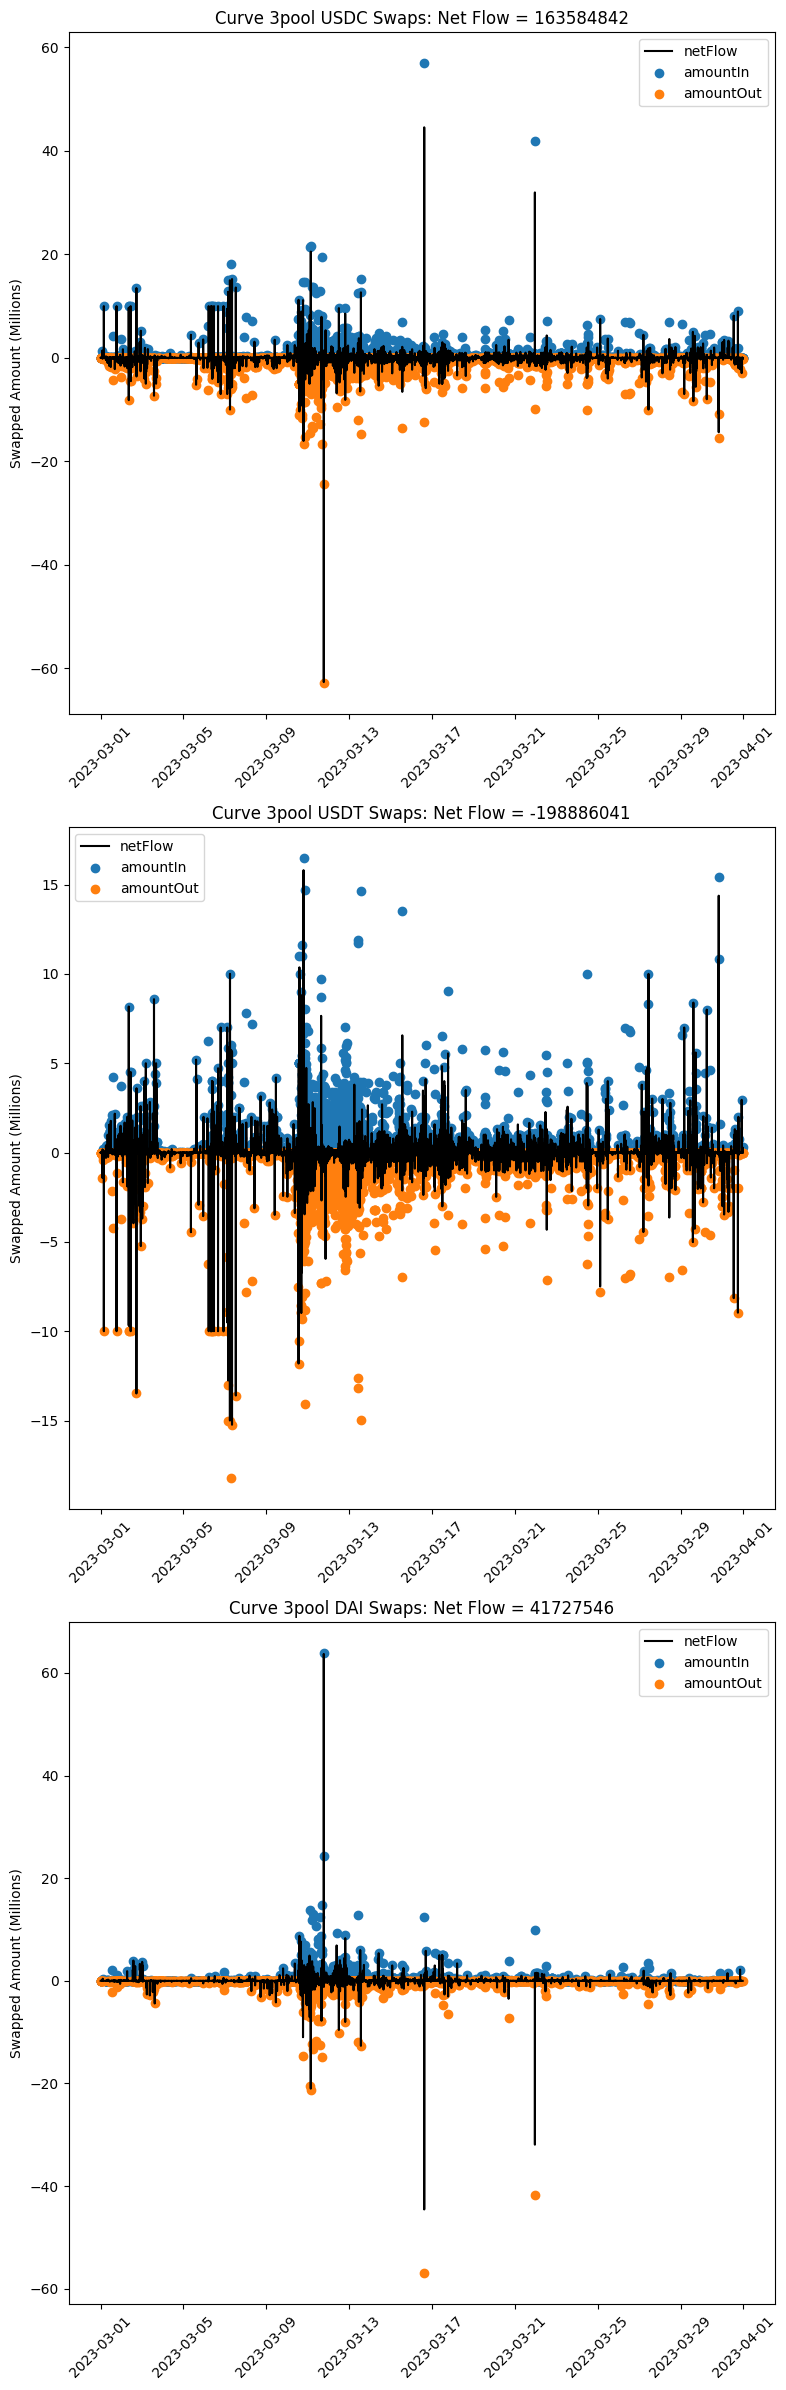

In [10]:
tokens = set(df_swaps['tokenIn.symbol'].unique().tolist() + df_swaps['tokenOut.symbol'].unique().tolist())
freq = '1min'

fig, axs = plt.subplots(len(tokens), 1, figsize=(8, 8*len(tokens)))

for i, token in enumerate(tokens):
    swap_in = df_swaps[df_swaps['tokenIn.symbol']==token]['amountIn'].resample(freq).sum()
    swap_out = -1*df_swaps[df_swaps['tokenOut.symbol']==token]['amountOut'].resample(freq).sum()
    flow = pd.concat([swap_in, swap_out], axis=1).fillna(0)
    flow['netFlow'] = flow['amountIn'] + flow['amountOut']

    maskIn = flow[flow['amountIn'] != 0]
    maskOut = flow[flow['amountOut'] != 0]

    axs[i].plot(flow.index, flow['netFlow']/1e6, label='netFlow', color='black')
    axs[i].scatter(maskIn.index, maskIn['amountIn']/1e6, label='amountIn')
    axs[i].scatter(maskOut.index, maskOut['amountOut']/1e6, label='amountOut')

    axs[i].set_ylabel('Swapped Amount (Millions)')
    axs[i].set_title(f"Curve {pool_name} {token} Swaps: Net Flow = {round(flow['netFlow'].sum())}")
    axs[i].tick_params(axis='x', rotation=45)

    axs[i].legend()

fig.tight_layout()

# Pool Composition Metrics

In [11]:
def shannon(x):
    """
    Imagine a pool is a basket and each unit of each asset is a ball with that asset's color.
    Shannon entropy [loosely] measures how easy it is to predict the color of a ball picked at random.
    """
    proportions = x / np.sum(x)
    entropy = -np.sum(proportions * np.log2(proportions))
    # print(f"The entropy of the pool is {entropy:.2f}")
    return entropy

def gini(x):
    """
    Gini coefficient measures the inequality in the pool.
    """
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    coef = total / (len(x)**2 * np.mean(x))
    # print(f"The Gini coefficient of the pool is {coef=:.2f}")
    return coef

In [12]:
df_pool['gini'] = df_pool[['DAI.weight', 'USDC.weight', 'USDT.weight']].apply(gini, axis=1)
df_pool['shannon'] = df_pool[['DAI.weight', 'USDC.weight', 'USDT.weight']].apply(shannon, axis=1)

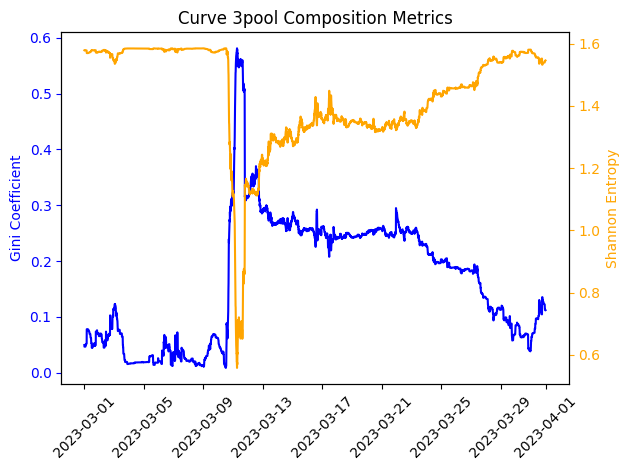

In [13]:
# NOTE: Maybe getting the rate of change of Gini or Shannon would be a good metric
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_pool.index, df_pool['gini'], label='gini', c='blue')
ax2.plot(df_pool.index, df_pool['shannon'], label='shannon', c='orange')

ax1.set_ylabel('Gini Coefficient', c='blue')
ax2.set_ylabel('Shannon Entropy', c='orange')

ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='orange')

ax1.set_title(f"Curve {pool_name} Composition Metrics")

fig.tight_layout()

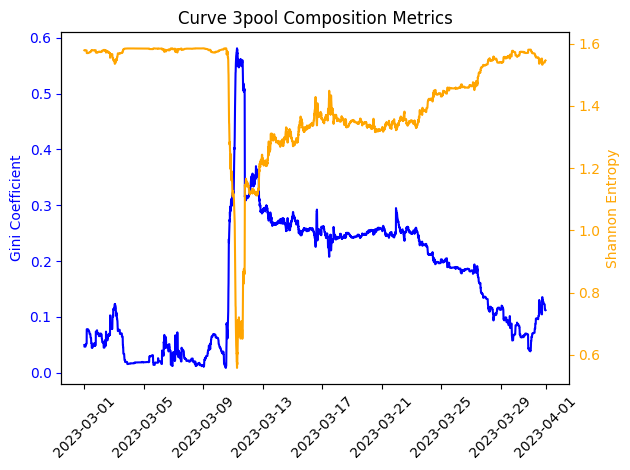

In [14]:
df_pool['gini'] = df_pool[['DAI.balance', 'USDC.balance', 'USDT.balance']].apply(gini, axis=1)
df_pool['shannon'] = df_pool[['DAI.balance', 'USDC.balance', 'USDT.balance']].apply(shannon, axis=1)

# NOTE: Maybe getting the rate of change of Gini or Shannon would be a good metric
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_pool.index, df_pool['gini'], label='gini', c='blue')
ax2.plot(df_pool.index, df_pool['shannon'], label='shannon', c='orange')

ax1.set_ylabel('Gini Coefficient', c='blue')
ax2.set_ylabel('Shannon Entropy', c='orange')

ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='orange')

ax1.set_title(f"Curve {pool_name} Composition Metrics")

fig.tight_layout()

# Deposits and Withdrawals

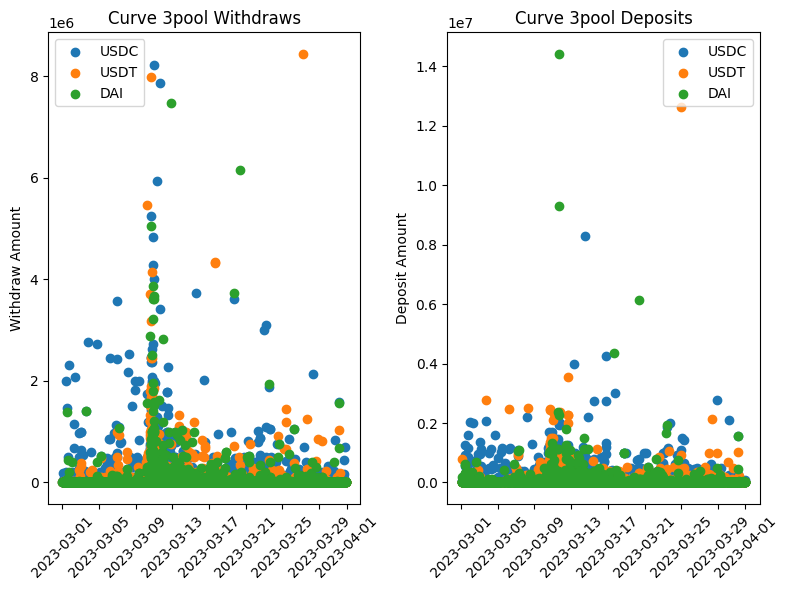

In [12]:
df_deposits = df_lp[df_lp['type']=='deposits']
df_withdraws = df_lp[df_lp['type']=='withdraws']

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].scatter(df_withdraws.index, df_withdraws['USDC.amount'], label='USDC')
axs[0].scatter(df_withdraws.index, df_withdraws['USDT.amount'], label='USDT')
axs[0].scatter(df_withdraws.index, df_withdraws['DAI.amount'], label='DAI')

axs[0].set_ylabel('Withdraw Amount')
axs[0].set_title(f"Curve {pool_name} Withdraws")
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

axs[1].scatter(df_deposits.index, df_deposits['USDC.amount'], label='USDC')
axs[1].scatter(df_deposits.index, df_deposits['USDT.amount'], label='USDT')
axs[1].scatter(df_deposits.index, df_deposits['DAI.amount'], label='DAI')

axs[1].set_ylabel('Deposit Amount')
axs[1].set_title(f"Curve {pool_name} Deposits")
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

fig.tight_layout()

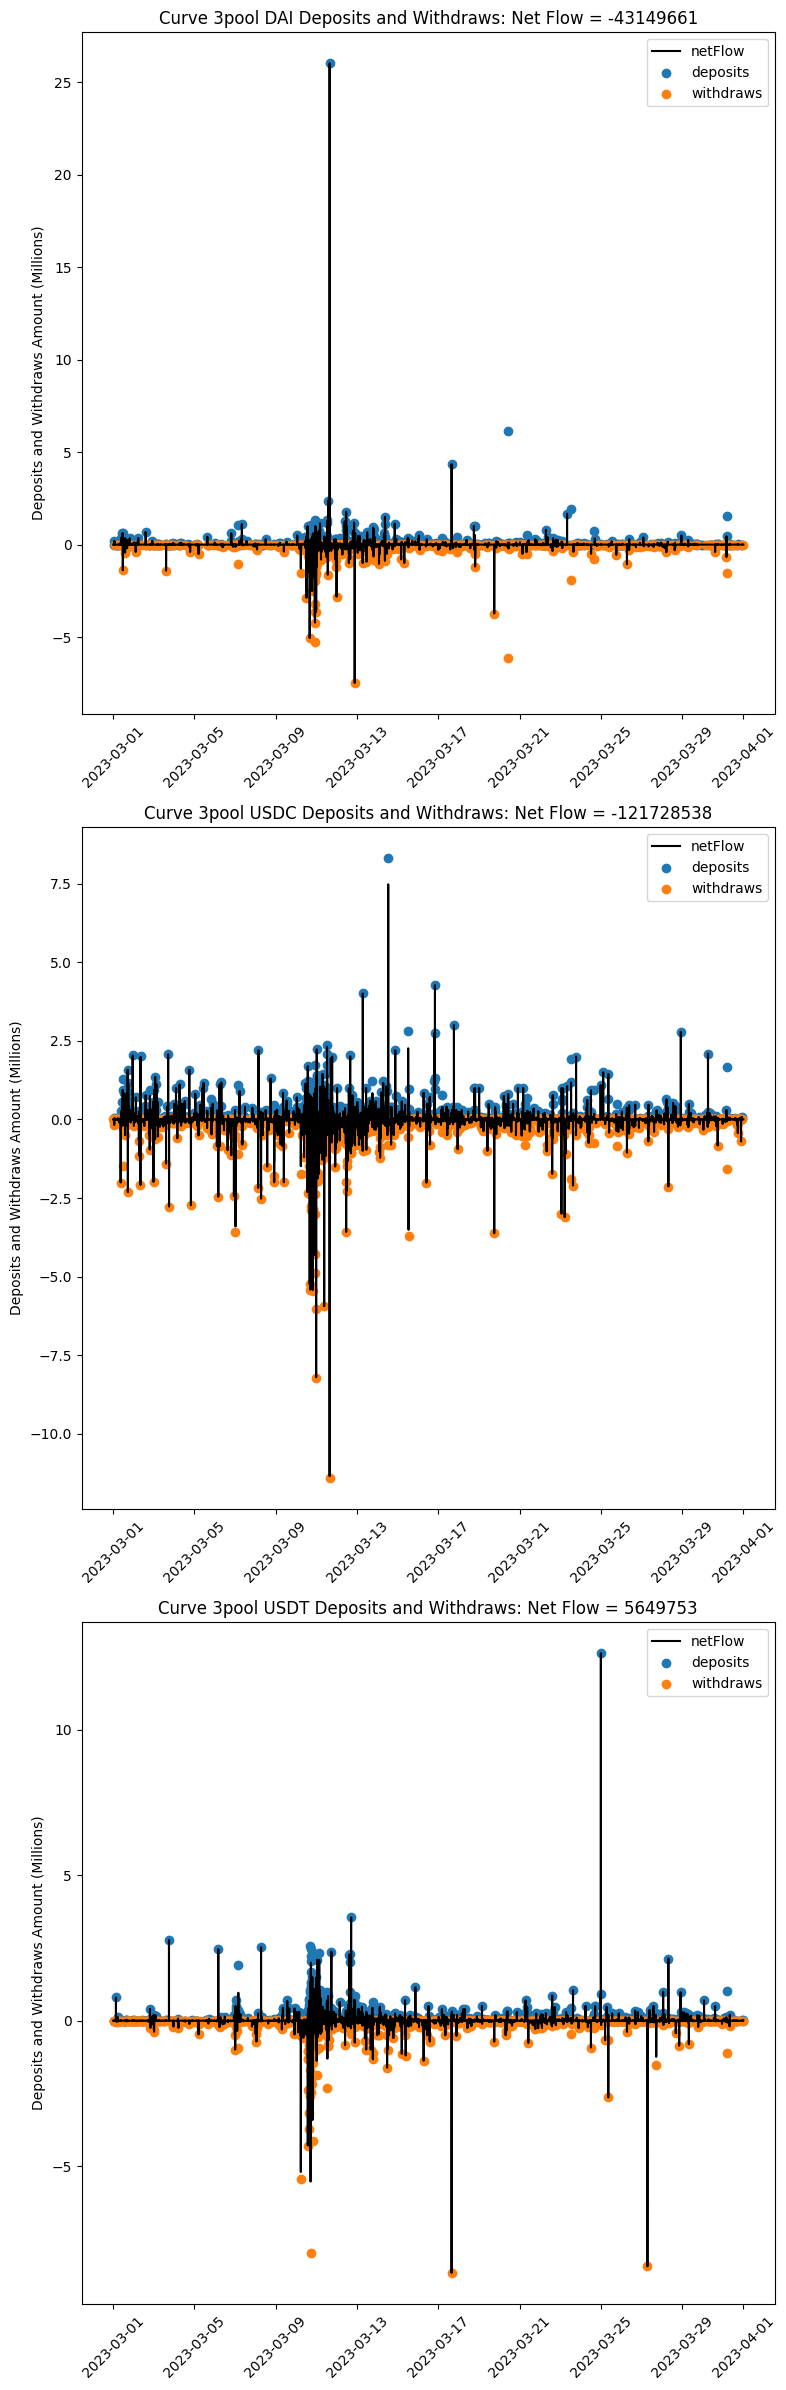

In [13]:
df_deposits = df_lp[df_lp['type']=='deposits']
df_withdraws = df_lp[df_lp['type']=='withdraws']

tokens = [col.replace('.amount', '') for col in df_withdraws.columns if '.amount' in col]
freq = '1min'

fig, axs = plt.subplots(len(tokens), 1, figsize=(8, 8*len(tokens)))

for i, token in enumerate(tokens):
    deposits = df_deposits[token+'.amount'].resample(freq).sum()
    deposits.name = 'deposits'
    withdraws = -1*df_withdraws[token+'.amount'].resample(freq).sum()
    withdraws.name = 'withdraws'
    
    flow = pd.concat([deposits, withdraws], axis=1).fillna(0)
    flow['netFlow'] = flow['deposits'] + flow['withdraws']

    mask_deposits = flow[flow['deposits'] != 0]
    mask_withdraws = flow[flow['withdraws'] != 0]

    axs[i].plot(flow.index, flow['netFlow']/1e6, label='netFlow', color='black')
    axs[i].scatter(mask_deposits.index, mask_deposits['deposits']/1e6, label='deposits')
    axs[i].scatter(mask_withdraws.index, mask_withdraws['withdraws']/1e6, label='withdraws')

    axs[i].set_ylabel('Deposits and Withdraws Amount (Millions)')
    axs[i].set_title(f"Curve {pool_name} {token} Deposits and Withdraws: Net Flow = {round(flow['netFlow'].sum())}")
    axs[i].tick_params(axis='x', rotation=45)

    axs[i].legend()

fig.tight_layout()

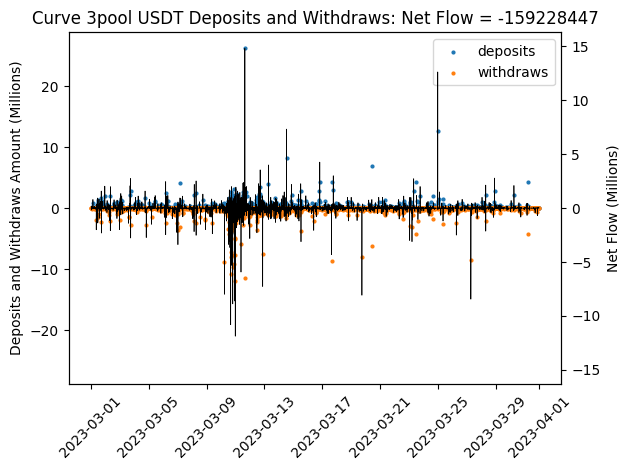

In [14]:
freq = '1min'

fig, ax = plt.subplots()

ax2 = ax.twinx()

deposits = df_deposits['amountUSD'].resample(freq).sum()
deposits.name = 'deposits'
withdraws = -1*df_withdraws['amountUSD'].resample(freq).sum()
withdraws.name = 'withdraws'

flow = pd.concat([deposits, withdraws], axis=1).fillna(0)
flow['netFlow'] = flow['deposits'] + flow['withdraws']

mask_deposits = flow[flow['deposits'] != 0]
mask_withdraws = flow[flow['withdraws'] != 0]

ax2.plot(flow.index, flow['netFlow']/1e6, label='netFlow', color='black', linewidth=0.5)
ax.scatter(mask_deposits.index, mask_deposits['deposits']/1e6, label='deposits', s=4)
ax.scatter(mask_withdraws.index, mask_withdraws['withdraws']/1e6, label='withdraws', s=4)

left_max = max(max(mask_deposits['deposits']/1e6), -1*min(mask_withdraws['withdraws']/1e6))*1.1
ax.set_ylim(-left_max, left_max)

right_max = max(abs(flow['netFlow']/1e6))*1.1
ax2.set_ylim(-right_max, right_max)
ax2.set_ylabel('Net Flow (Millions)')

ax.set_ylabel('Deposits and Withdraws Amount (Millions)')
ax.set_title(f"Curve {pool_name} {token} Deposits and Withdraws: Net Flow = {round(flow['netFlow'].sum())}")
ax.tick_params(axis='x', rotation=45)

ax.legend()

fig.tight_layout()

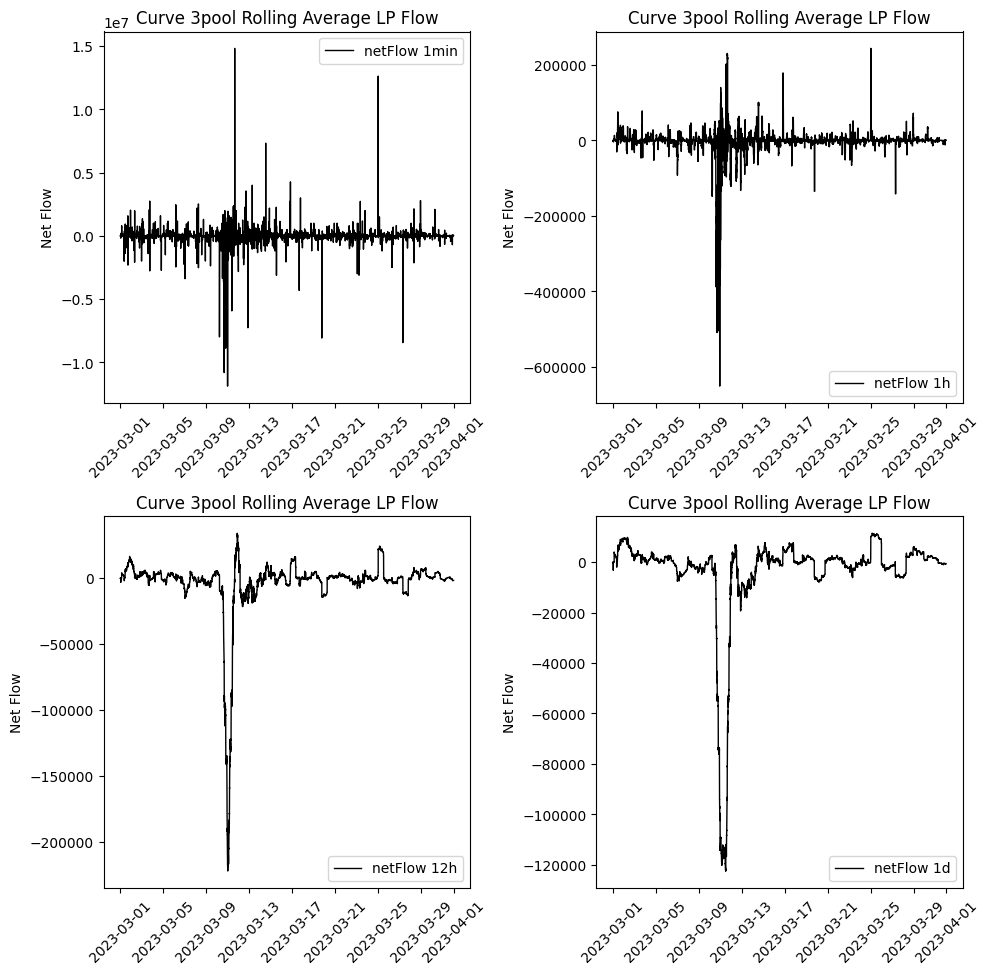

In [15]:
windows = ['1min', '1h', '12h', '1d']

n, m = 2, 2

fig, axs = plt.subplots(n, m, figsize=(10, 10))
count = 0
for i in range(n):
    for j in range(m):
        window = windows[count]
        axs[i, j].plot(flow.index, flow['netFlow'].rolling(window).mean(), label=f'netFlow {window}', color='black', linewidth=1)

        axs[i, j].set_ylabel('Net Flow')
        axs[i, j].set_title(f"Curve {pool_name} Rolling Average LP Flow")
        axs[i, j].tick_params(axis='x', rotation=45)

        axs[i, j].legend()
        count += 1

fig.tight_layout()

In [67]:
df_lp_cvx = datafetcher.get_lp_data(pool_name, source='cvx')
df_lp_cvx

3pool


,from,totalSupply,hash,DAI.amount,USDC.amount,USDT.amount,type,amountUSD,to
timestamp,,,,,,,,,
2023-03-01 03:06:11,0x239f007d328b36ae3332545061916eba9d15dc3c,5.027905e+08,0xdb565bd30f8cf86631dd63a0f70376cf526de7393339...,0.00000,90.38385,0.00000,withdraws,None,None
2023-03-01 03:41:23,0x99a58482bd75cbab83b27ec03ca68ff489b5788f,5.027865e+08,0x983af5da0a8201dae2a977b4e6becceca7ae241759ae...,0.00000,0.00000,4096.09140,withdraws,None,None
2023-03-01 03:52:23,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,5.027725e+08,0x0740ef6fe1f372b90936f773ccc6e6ac76342a54856a...,0.00000,14310.85259,0.00000,withdraws,None,None
2023-03-01 04:12:59,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,5.027726e+08,0x6e704fdccf37eab0bb3ebb7c05ac33ff593084901437...,0.00000,0.00000,70.94000,deposits,None,None
2023-03-01 04:21:47,0xa79828df1850e8a3a3064576f380d90aecdd3359,5.025955e+08,0x2ba6095518bfcd12bcd3ad8460746135b20d100b6649...,0.00000,0.00000,4251.97352,withdraws,None,None
...,...,...,...,...,...,...,...,...,...
2023-04-01 01:39:35,0xc9c32cd16bf7efb85ff14e0c8603cc90f6f2ee49,4.271405e+08,0xfb7f29dcd273ebb6ac2a085719e2cf503a4a83589ddd...,0.00000,914.70898,0.00000,withdraws,None,None
2023-04-01 02:10:59,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,4.271351e+08,0x48ca53cccca7f6f82f69521c1bd466008292d7dc131d...,0.00000,0.00000,4471.86000,deposits,None,None
2023-04-01 02:07:23,0x06cb22615ba53e60d67bf6c341a0fd5e718e1655,4.271307e+08,0x5c2a97803ace29a8f7535b71f48e3b6ef987f4901443...,0.00000,0.00000,2908.99508,withdraws,None,None


In [71]:
df_lp_cvx[['amountUSD', 'from', 'to', 'hash', 'DAI.amount', 'USDC.amount', 'USDT.amount', 'type', 'totalSupply']]

,amountUSD,from,to,hash,DAI.amount,USDC.amount,USDT.amount,type,totalSupply
timestamp,,,,,,,,,
2023-03-01 03:06:11,None,0x239f007d328b36ae3332545061916eba9d15dc3c,None,0xdb565bd30f8cf86631dd63a0f70376cf526de7393339...,0.00000,90.38385,0.00000,withdraws,5.027905e+08
2023-03-01 03:41:23,None,0x99a58482bd75cbab83b27ec03ca68ff489b5788f,None,0x983af5da0a8201dae2a977b4e6becceca7ae241759ae...,0.00000,0.00000,4096.09140,withdraws,5.027865e+08
2023-03-01 03:52:23,None,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,None,0x0740ef6fe1f372b90936f773ccc6e6ac76342a54856a...,0.00000,14310.85259,0.00000,withdraws,5.027725e+08
2023-03-01 04:12:59,None,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,None,0x6e704fdccf37eab0bb3ebb7c05ac33ff593084901437...,0.00000,0.00000,70.94000,deposits,5.027726e+08
2023-03-01 04:21:47,None,0xa79828df1850e8a3a3064576f380d90aecdd3359,None,0x2ba6095518bfcd12bcd3ad8460746135b20d100b6649...,0.00000,0.00000,4251.97352,withdraws,5.025955e+08
...,...,...,...,...,...,...,...,...,...
2023-04-01 01:39:35,None,0xc9c32cd16bf7efb85ff14e0c8603cc90f6f2ee49,None,0xfb7f29dcd273ebb6ac2a085719e2cf503a4a83589ddd...,0.00000,914.70898,0.00000,withdraws,4.271405e+08
2023-04-01 02:10:59,None,0x97adc08fa1d849d2c48c5dcc1dab568b169b0267,None,0x48ca53cccca7f6f82f69521c1bd466008292d7dc131d...,0.00000,0.00000,4471.86000,deposits,4.271351e+08
2023-04-01 02:07:23,None,0x06cb22615ba53e60d67bf6c341a0fd5e718e1655,None,0x5c2a97803ace29a8f7535b71f48e3b6ef987f4901443...,0.00000,0.00000,2908.99508,withdraws,4.271307e+08


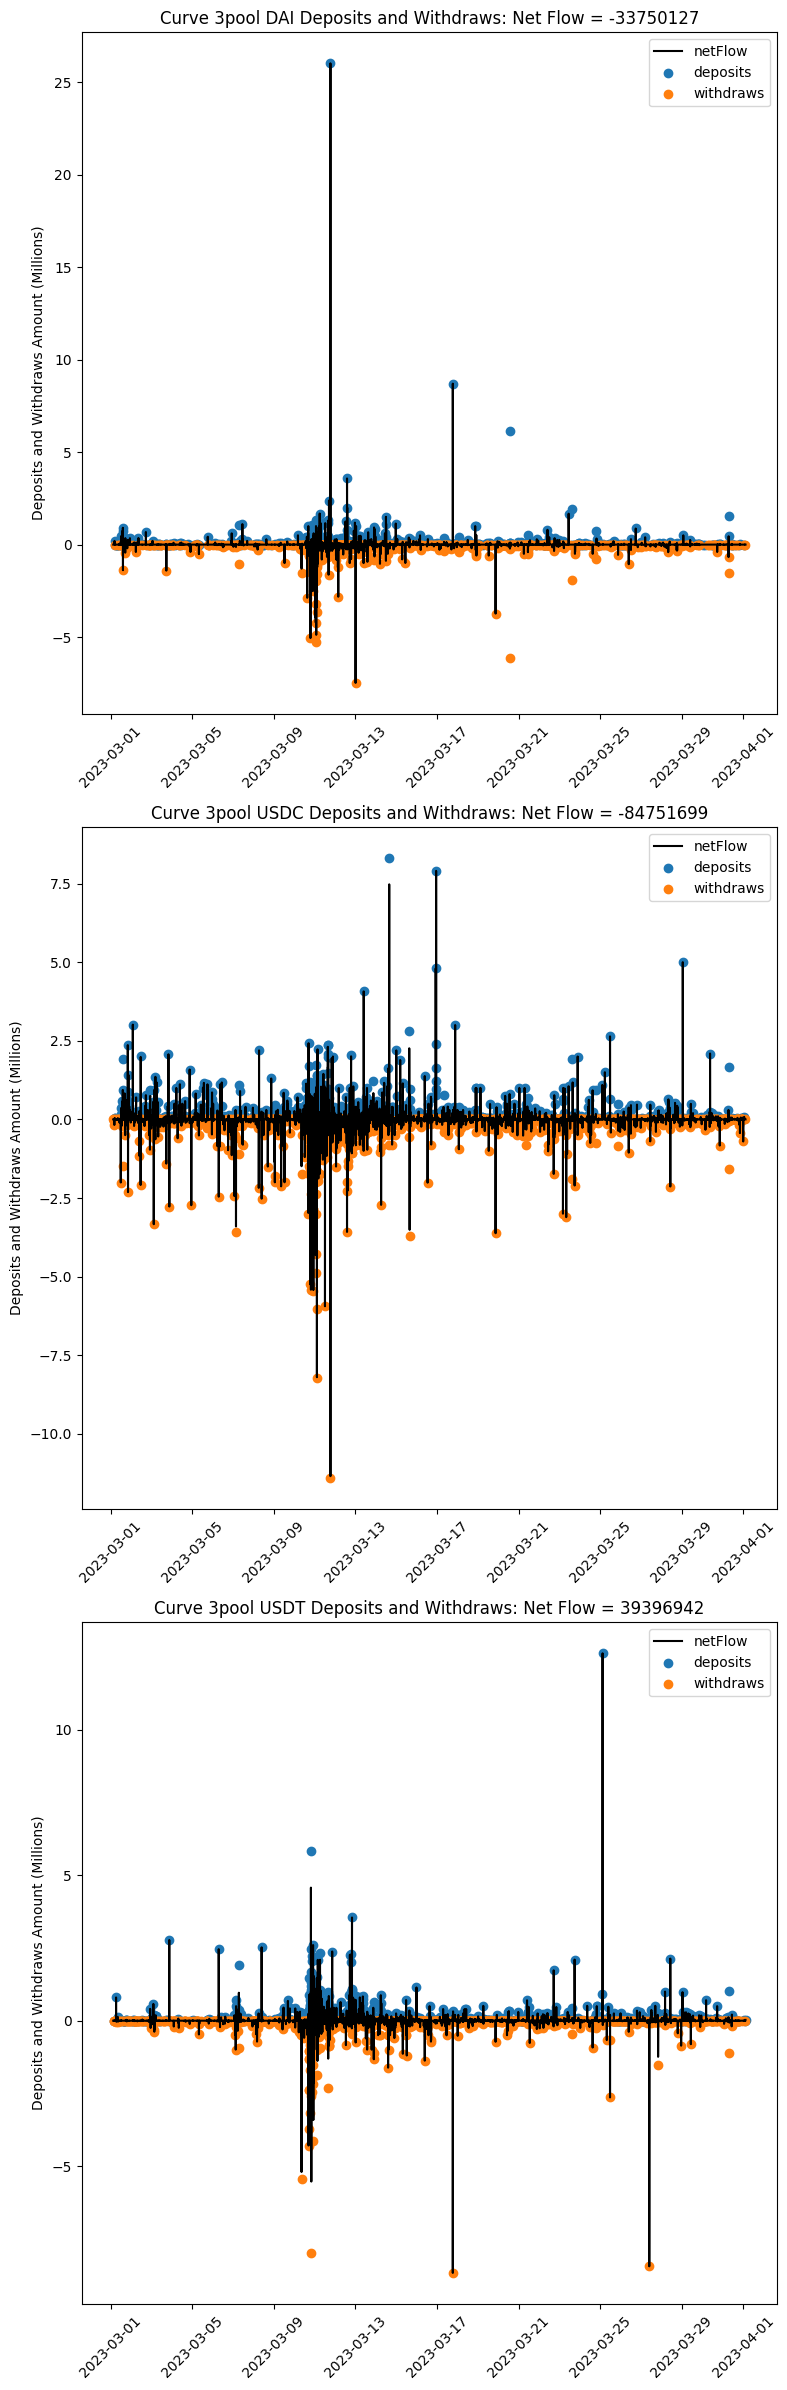

In [73]:
df_deposits = df_lp_cvx[df_lp_cvx['type']=='deposits']
df_withdraws = df_lp_cvx[df_lp_cvx['type']=='withdraws']

tokens = [col.replace('.amount', '') for col in df_withdraws.columns if '.amount' in col]
freq = '1min'

fig, axs = plt.subplots(len(tokens), 1, figsize=(8, 8*len(tokens)))

for i, token in enumerate(tokens):
    deposits = df_deposits[token+'.amount'].resample(freq).sum()
    deposits.name = 'deposits'
    withdraws = -1*df_withdraws[token+'.amount'].resample(freq).sum()
    withdraws.name = 'withdraws'
    
    flow = pd.concat([deposits, withdraws], axis=1).fillna(0)
    flow['netFlow'] = flow['deposits'] + flow['withdraws']

    mask_deposits = flow[flow['deposits'] != 0]
    mask_withdraws = flow[flow['withdraws'] != 0]

    axs[i].plot(flow.index, flow['netFlow']/1e6, label='netFlow', color='black')
    axs[i].scatter(mask_deposits.index, mask_deposits['deposits']/1e6, label='deposits')
    axs[i].scatter(mask_withdraws.index, mask_withdraws['withdraws']/1e6, label='withdraws')

    axs[i].set_ylabel('Deposits and Withdraws Amount (Millions)')
    axs[i].set_title(f"Curve {pool_name} {token} Deposits and Withdraws: Net Flow = {round(flow['netFlow'].sum())}")
    axs[i].tick_params(axis='x', rotation=45)

    axs[i].legend()

fig.tight_layout()